# Load Point Data for Kernel Density Calculations
## Author: R. Chadwick Holmes

### Purpose: convert point data features to density maps for use in machine learning pipelines
### Data pre-processing script applied before Data Conditioning workflow\

MASSACHUSETTS INSTITUTE OF TECHNOLOGY<br>
SYSTEM DESIGN & MANAGEMENT<br>
Author: R. Chadwick Holmes<br>
Date: December 5. 2021<br><br>
Script Purpose:<br>
Convert point data features to density maps for use in machine learning pipelines.
<br><br>

In [ ]:
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirement
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes cartopy
!pip uninstall -y shapely
!pip install shapely --no-binary shapely
!pip install dataprep --no-binary dataprep

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubun

In [ ]:
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

from pathlib import Path
import pickle

from matplotlib import cm
from matplotlib.colors import ListedColormap

import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = r'/content/drive/MyDrive/Colab Notebooks/Data'
datafolder = Path(path) 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
n = 2

feats = ['Earthquakes','Vents','Springs']
files = ['Earthquakes.csv','Vents.csv','Springs.csv']

featdata = feats[n]
data = files[n]

# read data into pandas dataframe
featdf = pd.read_csv(datafolder / data)
featdf.head()

,OID_,agency_cd,site_no,Latitude,Longitude,coord_acy_cd,dec_coord_datum_cd,huc_cd,basin_cd,topo_cd
0,1,USGS,8405301.0,32.109838,-104.472171,S,NAD83,13060011.0,NaN,NaN
1,2,USGS,8405303.0,32.110672,-104.471337,S,NAD83,13060011.0,NaN,NaN
2,3,USGS,8405490.0,32.199841,-104.254110,U,NAD83,13060011.0,NaN,NaN
3,4,USGS,8480594.0,33.287500,-106.309167,U,NAD83,13050003.0,NaN,NaN
4,5,USGS,9505260.0,34.647800,-111.751261,T,NAD83,15060202.0,NaN,G


In [ ]:
seed = 43

xmin,xmax,ymin,ymax = [-109.1, -105.9, 31.3, 35.4]
extent = [xmin,xmax,ymin,ymax]

# define AOI 

# 1. can do this with restrictive exploration area polygon
#aoi = gpd.read_file(data_folder / r'Exploration_area.shp')
#aoi = aoi.geometry[0]

# 2. or can use less restrictive extents
aoi = Polygon([(xmin,ymin),(xmax,ymin),(xmax,ymax),(xmin,ymax),(xmin,ymin)])

### Read in point locations

In [ ]:
pt_file = r'AOI_grid_0p025_degrees.csv'
pointsdf = pd.read_csv(Path(path,pt_file))
print(pointsdf.shape)
print(pointsdf.head())

(15137, 3)
   OID_   Latitude  Longitude
0     1  31.337505 -109.03751
1     2  31.337505 -109.01251
2     3  31.337505 -108.98751
3     4  31.337505 -108.96251
4     5  31.337505 -108.93751


### Manage data as geographic in nature

In [ ]:
# assume coordinates are in compliance with WGS84 ellipsoid (See link below)
#https://www.usgs.gov/faqs/what-map-projections-are-used-national-map-tiled-base-map-services-and-dynamic-overlay-services?qt-news_science_products=0#qt-news_science_products
gdf = gpd.GeoDataFrame(featdf, geometry=gpd.points_from_xy(featdf.Longitude, featdf.Latitude),crs = {'init': 'epsg:4326'})

# drop points outside of AOI
gdf = gdf[gdf.within(aoi)].reset_index(drop=True)
gdf

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,OID_,agency_cd,site_no,Latitude,Longitude,coord_acy_cd,dec_coord_datum_cd,huc_cd,basin_cd,topo_cd,geometry
0,4,USGS,8.480594e+06,33.287500,-106.309167,U,NAD83,13050003.0,NaN,NaN,POINT (-106.30917 33.28750)
1,97,USGS,3.150400e+14,31.845933,-107.985587,U,NAD83,13030201.0,NaN,NaN,POINT (-107.98559 31.84593)
2,169,USGS,3.206050e+14,32.093703,-107.610858,U,NAD83,13030202.0,NaN,NaN,POINT (-107.61086 32.09370)
3,175,USGS,3.208280e+14,32.141202,-107.627803,U,NAD83,13030202.0,NaN,NaN,POINT (-107.62780 32.14120)
4,226,USGS,3.218490e+14,32.313705,-106.515827,U,NAD83,13050003.0,NaN,NaN,POINT (-106.51583 32.31370)
...,...,...,...,...,...,...,...,...,...,...,...
433,1693,USGS,3.521430e+14,35.361968,-109.041757,T,NAD83,15020006.0,NaN,NaN,POINT (-109.04176 35.36197)
434,1696,USGS,3.522080e+14,35.368921,-107.592832,U,NAD83,13020205.0,NaN,NaN,POINT (-107.59283 35.36892)
435,1699,USGS,3.522200e+14,35.372255,-107.557553,U,NAD83,13020205.0,NaN,NaN,POINT (-107.55755 35.37225)
436,1720,USGS,3.523550e+14,35.398649,-106.096967,F,NAD83,13020201.0,NaN,S,POINT (-106.09697 35.39865)


In [ ]:
# convert to NM projection (NAD83 / New Mexico Central)
#gdf.to_crs(epsg=32113, inplace=True)
xy_crs = 32662

# convert to 
gdf.to_crs(epsg=xy_crs, inplace=True)
gdf['Location'] =  list(zip(gdf.Longitude, gdf.Latitude))

# expand X and Y columns
gdf['X'] = gdf['geometry'].x
gdf['Y'] = gdf['geometry'].y

In [ ]:
myprojection = ccrs.PlateCarree()

def createBasemap():
    expl_area = datafolder / 'Exploration_area.shp'
    expl_area_feat = ShapelyFeature(Reader(expl_area).geometries(), crs=myprojection, edgecolor='black')

    rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m')
    #stamen_terrain = cimgt.Stamen('terrain-background')

    # generate plot of NM with river and stock image
    plt.figure(figsize=(20,12))
    ax = plt.axes(projection=myprojection)

    # Add the Stamen data at zoom level 9.
    ax.stock_img()
    #ax.add_image(stamen_terrain, 9)
    
    ax.add_feature(cartopy.feature.STATES)
    ax.add_feature(rivers_50m, facecolor='None', edgecolor='b')
    ax.add_feature(expl_area_feat, facecolor='None', edgecolor='r', linewidth=2, alpha = 0.5)

    ax.set_extent(extent,crs=myprojection)
    
    return ax

In [ ]:
# make a version of viridis colormap with lower tip white (to block out 0-valued data)
cmap = cm.get_cmap('viridis', 256)
cmaptips = cmap(np.linspace(0,1,256))
tipclr = np.array([1,1,1,1])
cmaptips[0,:] = tipclr
#cmaptips[-1,:] = tipclr
newcmap = ListedColormap(cmaptips)
#print('viridis.colors', newcmap.colors)

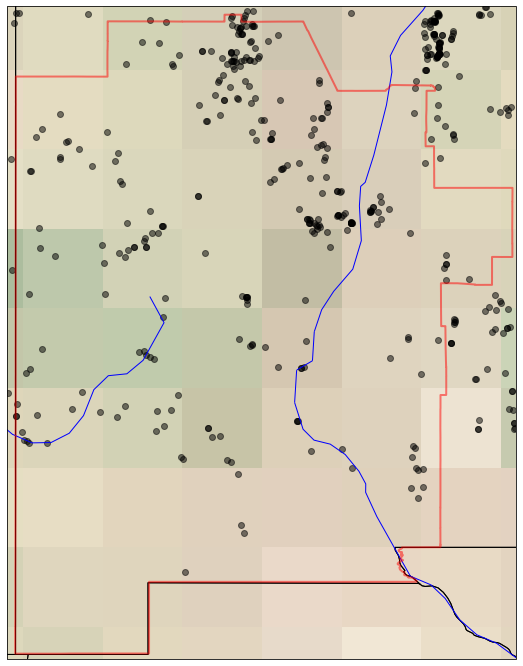

In [ ]:
ax = createBasemap();

# plot locations
ax.scatter(gdf.Longitude,
           gdf.Latitude,
           #s=((gdf.Magnitude-np.mean(gdf.Magnitude))/np.std(gdf.Magnitude))*20,
           color='black',
           alpha=0.5,
           transform=myprojection);

In [ ]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

bwvals = np.linspace(5000, 50000,451)

grid = GridSearchCV(KernelDensity(kernel='gaussian'), 
                    {'bandwidth': bwvals},
                     n_jobs=-1,
                     verbose=4,
                     refit=True,
                     return_train_score=True,
                     cv=10) # 10-fold cross-validation
grid.fit(gdf[['X','Y']])
print(grid.best_params_)

Fitting 10 folds for each of 451 candidates, totalling 4510 fits
{'bandwidth': 31400.0}


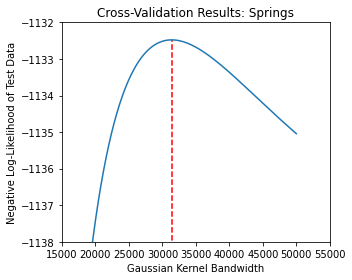

In [ ]:
df = pd.DataFrame(grid.cv_results_)
fig=plt.figure(figsize=(5,4))
plt.plot(bwvals,df.mean_test_score)
plt.title('Cross-Validation Results: {}'.format(featdata))
plt.xlabel('Gaussian Kernel Bandwidth')
plt.vlines(grid.best_params_['bandwidth'],
           ymin=min(df.mean_test_score),
           ymax=max(df.mean_test_score),
           colors='r',linestyle='--')
plt.ylabel('Negative Log-Likelihood of Test Data');
if(n==0):
  plt.xlim([3000,53000])
  plt.ylim([-2595,-2521])
elif(n==1):
  plt.xlim([15001,54000])
  plt.ylim([-1020,-1010])
else:
  plt.xlim([15000,55000])
  plt.ylim([-1138,-1132])
fig.tight_layout()
plt.savefig(datafolder / 'Figure-{}_kde_gridsearchcv_result.png'.format(featdata), dpi=200, bbox_inches='tight')

## Save/load model file

In [ ]:
mod_file = 'finalized_model_{}_gp_ls{:.0f}.sav'.format(featdata,grid.best_params_['bandwidth'])
mod_file

'finalized_model_Springs_gp_ls31400.sav'

In [ ]:
# save the model to disk
pickle.dump(grid.best_estimator_,open(datafolder / mod_file,'wb'))

In [ ]:
# test loading the model from disk
gp = pickle.load(open(datafolder / mod_file, 'rb'))

## Apply model to coordinate grid

In [ ]:
bmdf = pointsdf[['Longitude','Latitude']]

bmgdf = gpd.GeoDataFrame(bmdf, geometry=gpd.points_from_xy(bmdf.Longitude, bmdf.Latitude),crs = {'init': 'epsg:4326'})
bmgdf.to_crs(epsg=xy_crs,inplace=True)
bmgdf['X'] = bmgdf['geometry'].x
bmgdf['Y'] = bmgdf['geometry'].y

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
Z = grid.best_estimator_.score_samples(bmgdf[['X','Y']])
Z

array([-36.89430583, -36.64006611, -36.37824972, ..., -24.80627398,
       -24.79805457, -24.79611708])

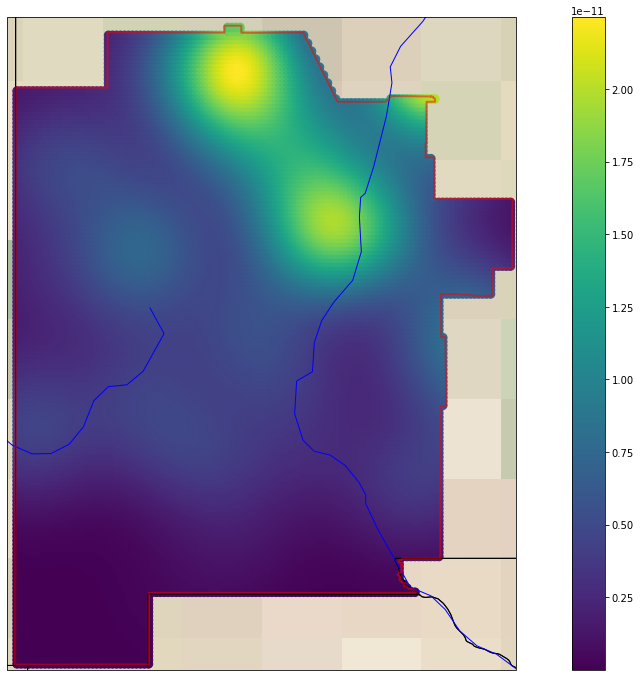

In [ ]:
ax = createBasemap();
pc= ax.scatter(bmdf['Longitude'],
               bmdf['Latitude'],
               s=75,
               c=np.exp(Z),
               alpha=1.0,
               #vmin=0, 
               #vmax=10,
               transform=myprojection);
plt.colorbar(pc,ax=ax);

In [ ]:
outdf = bmgdf.drop(['geometry'],axis=1)
outdf[featdata] = Z
print(outdf.shape)
outdf.head()

(15137, 5)


,Longitude,Latitude,X,Y,Springs
0,-109.03751,31.337505,-1.213800e+07,3.488475e+06,-36.894306
1,-109.01251,31.337505,-1.213522e+07,3.488475e+06,-36.640066
2,-108.98751,31.337505,-1.213243e+07,3.488475e+06,-36.378250
3,-108.96251,31.337505,-1.212965e+07,3.488475e+06,-36.111525
4,-108.93751,31.337505,-1.212687e+07,3.488475e+06,-35.842360


In [ ]:
outdf.to_csv(datafolder / 'feature_{}_kd_rad{:.0f}.csv'.format(featdata,grid.best_params_['bandwidth']))